In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Disable warnings and set pandas options to avoid hanging
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.use_inf_as_na = False

# Print versions for debugging
print(f"PyTorch version: {torch.__version__}")
print(f"Pandas version: {pd.__version__}")

In [ ]:
# Define dataset path
DATASET_PATH = "/kaggle/input/skin-cancer-the-ham10000-dataset"

# Image folders (including test images if needed)
IMAGE_PATHS = [
    os.path.join(DATASET_PATH, "HAM10000_images_part_1"),
    os.path.join(DATASET_PATH, "HAM10000_images_part_2"),
    os.path.join(DATASET_PATH, "ISIC2018_Task3_Test_Images")
]

# Metadata file
METADATA_PATH = os.path.join(DATASET_PATH, "HAM10000_metadata.csv")

# Print progress to debug where hanging occurs
print("Step 1: Loading metadata...")
metadata = pd.read_csv(METADATA_PATH)
print(f"Loaded metadata with {len(metadata)} rows")

# Create a simple image path lookup dictionary
print("Step 2: Creating image path lookup dictionary...")
image_path_dict = {}
for path in IMAGE_PATHS:
    if os.path.exists(path):
        print(f"Processing directory: {path}")
        files = os.listdir(path)
        print(f"Found {len(files)} files in directory")
        for img_file in files:
            if img_file.endswith('.jpg'):
                image_id = img_file.split('.')[0]
                image_path_dict[image_id] = os.path.join(path, img_file)

print(f"Found {len(image_path_dict)} images total")

Step 3: Creating basic dataset visualization...


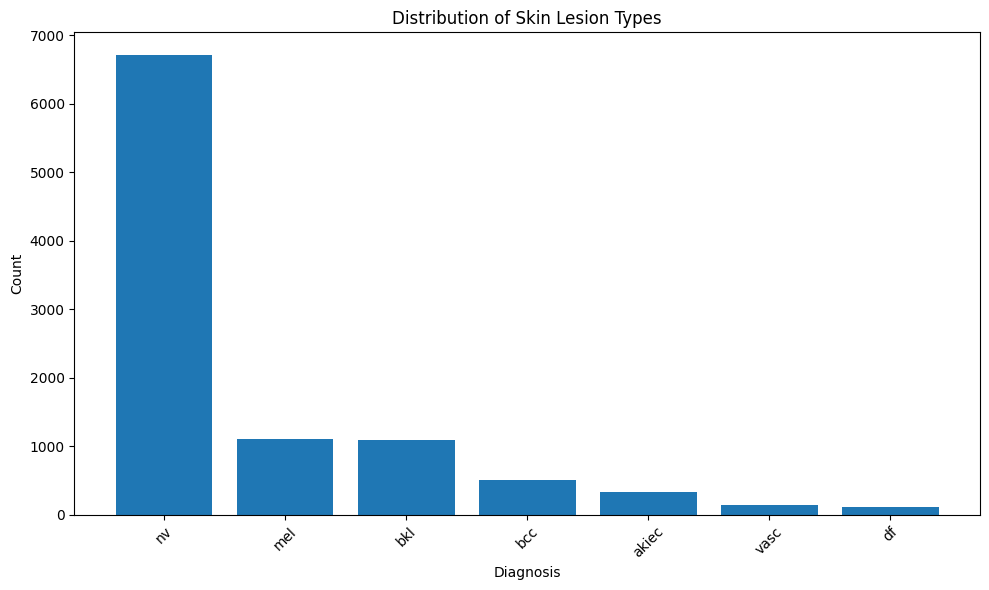

Dataset visualization saved successfully


In [3]:
# Plot simple diagnosis distribution
print("Step 3: Creating basic dataset visualization...")
try:
    plt.figure(figsize=(10, 6))
    diagnosis_counts = metadata['dx'].value_counts()
    plt.bar(diagnosis_counts.index, diagnosis_counts.values)
    plt.title('Distribution of Skin Lesion Types')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("Dataset visualization saved successfully")
except Exception as e:
    print(f"Error creating visualization: {e}")

In [ ]:
# Map diagnosis labels to numerical classes
print("Step 4: Creating label mapping...")
label_mapping = {label: idx for idx, label in enumerate(metadata["dx"].unique())}
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
metadata["label"] = metadata["dx"].map(label_mapping)

print("Label Mapping:")
for label, idx in label_mapping.items():
    print(f"{label}: {idx}")

# Train-validation split
print("Step 5: Splitting data...")
train_data, val_data = train_test_split(metadata, test_size=0.2, stratify=metadata["label"], random_state=42)
print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")

# Function to find image path
def find_image_path(image_id):
    # Use the dictionary for fast lookup instead of checking files
    return image_path_dict.get(image_id)

In [ ]:
# Custom dataset class
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = find_image_path(row["image_id"])
        
        # Handle missing images
        if img_path is None:
            # Return a blank image instead of raising an error
            image = Image.new('RGB', (224, 224), color='black')
            print(f"Warning: Image {row['image_id']}.jpg not found. Using blank image.")
        else:
            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(f"Error opening image {img_path}: {e}")
                image = Image.new('RGB', (224, 224), color='black')
        
        label = row["label"]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [ ]:
# Define image transformations
print("Step 6: Setting up data transforms...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
print("Step 7: Creating datasets...")
try:
    train_dataset = HAM10000Dataset(train_data, transform=transform)
    val_dataset = HAM10000Dataset(val_data, transform=val_transform)
    print("Datasets created successfully")
except Exception as e:
    print(f"Error creating datasets: {e}")

In [ ]:
# Create DataLoaders with reduced workers
print("Step 8: Creating data loaders...")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
print("Data loaders created successfully")

# Load pre-trained model
print("Step 9: Loading model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)

# Modify the classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(label_mapping))
model = model.to(device)
print("Model loaded successfully")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create arrays to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Simplified validation function
def validate_model(model, criterion, dataloader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(dataloader) if len(dataloader) > 0 else 0
    val_accuracy = 100 * correct / total if total > 0 else 0
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
    
    return val_loss, val_accuracy

In [ ]:
# Simple function to save a training plot
def save_training_plot(train_losses, val_losses, train_accuracies, val_accuracies, epoch):
    print(f"Saving training plot for epoch {epoch}...")
    try:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Accuracy vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(f"training_progress_epoch_{epoch}.png")
        plt.close()
        print("Plot saved successfully")
    except Exception as e:
        print(f"Error saving plot: {e}")

# Training function
print("Step 10: Starting training...")

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            if i % 10 == 0:
                print(f"  Processing batch {i}")
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            batch_count += 1
        
        # Calculate epoch stats
        epoch_loss = running_loss / batch_count if batch_count > 0 else 0
        epoch_accuracy = 100 * correct / total if total > 0 else 0
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
        
        # Validate the model
        print("Running validation...")
        val_loss, val_accuracy = validate_model(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_resnet50_ham10000.pth')
            print(f"✅ New best model saved with validation accuracy: {val_accuracy:.2f}%")
        
        # Plot training progress every 2 epochs
        if (epoch + 1) % 2 == 0 or epoch == num_epochs - 1:
            save_training_plot(train_losses, val_losses, train_accuracies, val_accuracies, epoch + 1)

In [ ]:
# Run training with fewer epochs for testing
print("Training model...")
try:
    train_model(model, criterion, optimizer, num_epochs=10)
    print("✅ Training completed successfully!")
except Exception as e:
    print(f"Error during training: {e}")

# Create a simple confusion matrix after training
print("Creating confusion matrix...")
try:
    # Get predictions
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[reverse_label_mapping[i] for i in range(len(label_mapping))],
                yticklabels=[reverse_label_mapping[i] for i in range(len(label_mapping))])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    plt.close()
    print("Confusion matrix saved successfully")
except Exception as e:
    print(f"Error creating confusion matrix: {e}")


In [2]:
# Save the trained model
torch.save(model.state_dict(), 'resnet50_ham10000_final.pth')

print("✅ All done! Model saved as resnet50_ham10000_final.pth")
print("✅ Best model saved as best_resnet50_ham10000.pth")
print("✅ Visualizations have been saved to the current directory")

PyTorch version: 2.5.1+cu121
Pandas version: 2.2.3
Step 1: Loading metadata...
Loaded metadata with 10015 rows
Step 2: Creating image path lookup dictionary...
Processing directory: /kaggle/input/skin-cancer-the-ham10000-dataset/HAM10000_images_part_1
Found 5000 files in directory
Processing directory: /kaggle/input/skin-cancer-the-ham10000-dataset/HAM10000_images_part_2
Found 5015 files in directory
Processing directory: /kaggle/input/skin-cancer-the-ham10000-dataset/ISIC2018_Task3_Test_Images
Found 1511 files in directory
Found 11526 images total
Step 3: Creating basic dataset visualization...
Dataset visualization saved successfully
Step 4: Creating label mapping...
Label Mapping:
bkl: 0
nv: 1
df: 2
mel: 3
vasc: 4
bcc: 5
akiec: 6
Step 5: Splitting data...
Training set: 8012 samples
Validation set: 2003 samples
Step 6: Setting up data transforms...
Step 7: Creating datasets...
Datasets created successfully
Step 8: Creating data loaders...
Data loaders created successfully
Step 9: Loa

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Model loaded successfully
Step 10: Starting training...
Training model...
Starting epoch 1/10
  Processing batch 0
  Processing batch 10
  Processing batch 20
  Processing batch 30
  Processing batch 40
  Processing batch 50
  Processing batch 60
  Processing batch 70
  Processing batch 80
  Processing batch 90
  Processing batch 100
  Processing batch 110
  Processing batch 120
  Processing batch 130
  Processing batch 140
  Processing batch 150
  Processing batch 160
  Processing batch 170
  Processing batch 180
  Processing batch 190
  Processing batch 200
  Processing batch 210
  Processing batch 220
  Processing batch 230
  Processing batch 240
  Processing batch 250
Epoch [1/10], Loss: 0.9287, Accuracy: 67.99%
Running validation...
Validation Loss: 0.8963, Accuracy: 69.25%
✅ New best model saved with validation accuracy: 69.25%
Starting epoch 2/10
  Processing batch 0
  Processing batch 10
  Processing batch 20
  Processing batch 30
  Processing batch 40
  Processing batch 50
  P

KeyboardInterrupt: 